In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import healpy as hp
import fitsio as ft
import numpy as np

import matplotlib.backends.backend_pdf

import sys
sys.path.append('/home/mehdi/github/LSSutils')
import LSSutils.dataviz as dv

from LSSutils.io import readnbodykit
from LSSutils.utils import (hpixsum, shiftra, 
                            steradian2sqdeg, hpix2radec, overdensity)

camb is not installed!


# N(z)

In [3]:
!head -n 3 /B/Shared/mehdi/eboss/data/v7_2/nbar_eBOSS_QSO_*GC_v7_2.dat

==> /B/Shared/mehdi/eboss/data/v7_2/nbar_eBOSS_QSO_NGC_v7_2.dat <==
# effective area (deg^2), effective volume (Mpc/h)^3: 2860.4406814189183 99740127.64438488
# zcen,zlow,zhigh,nbar,wfkp,shell_vol,total weighted gals
0.005 0.0 0.01 0.00013462213635665303 0.5976890894834057 7771.038808820277 1.046153846153846

==> /B/Shared/mehdi/eboss/data/v7_2/nbar_eBOSS_QSO_SGC_v7_2.dat <==
# effective area (deg^2), effective volume (Mpc/h)^3: 1838.8730140161808 53674436.18509478
# zcen,zlow,zhigh,nbar,wfkp,shell_vol,total weighted gals
0.005 0.0 0.01 0.00020558148614182404 0.4931191556659562 4995.717495292908 1.027027027027027


In [4]:
2860.4406814189183 + 1838.8730140161808

4699.313695435099

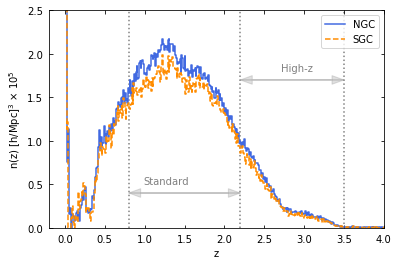

In [7]:
#plt.rc('font', family='serif', size=15)

path_nbar = '/B/Shared/mehdi/eboss/data/v7_2/'
nbar_ngc = np.loadtxt(f'{path_nbar}nbar_eBOSS_QSO_NGC_v7_2.dat')
nbar_sgc = np.loadtxt(f'{path_nbar}nbar_eBOSS_QSO_SGC_v7_2.dat')


fig, ax = plt.subplots(figsize=(6, 4))

kw = dict(where='mid')
ax.step(nbar_ngc[:,0], nbar_ngc[:, 3]/1.0e-5, label='NGC', ls='-', color='royalblue', **kw)
ax.step(nbar_sgc[:,0], nbar_sgc[:, 3]/1.0e-5, label='SGC', ls='--', color='darkorange', **kw)

samples = ['Standard', 'High-z']
lines  = [0.8, 2.2, 3.5]
for i, line in enumerate(lines):
    ax.axvline(line, zorder=0, ls=':', color='grey')
    
    if i<2:
        #-- annotation
        if i==0:
            ypos = 0.5
        else:
            ypos = 1.8
            
        ax.text(1.23*line, ypos, samples[i], color='grey')
        
        hwidth=0.1
        width=0.001
        kw = dict(shape='full', width=width, 
                  head_width=hwidth, color='grey', alpha=0.25)  
        
        # left to right
        ax.arrow(lines[i], ypos-0.1, lines[i+1]-lines[i]-1.5*hwidth, 0.0, **kw)        
        # right to left
        ax.arrow(lines[i+1], ypos-0.1, -lines[i+1]+lines[i]+1.5*hwidth, 0.0, **kw) 

ax.tick_params(direction='in', which='both', axis='both', pad=6, right=True, top=True)
ax.set(xlabel='z', ylabel=r'n(z) [h/Mpc]$^{3}$ $\times$ 10$^{5}$', 
       ylim=(0, 2.5), xlim=(-0.2, 4))
ax.legend()
fig.savefig('figs/fig1-nz.pdf', bbox_inches='tight')

# Mollweide

In [10]:
path_cats = '/B/Shared/mehdi/eboss/data/v7_2/0.3/'
dNGC = ft.read(f'{path_cats}eBOSS_QSO_clustering_NGC_v7_2_0.3.dat.fits')
rNGC = ft.read(f'{path_cats}eBOSS_QSO_clustering_NGC_v7_2_0.3.ran.fits')

dSGC = ft.read(f'{path_cats}eBOSS_QSO_clustering_SGC_v7_2_0.3.dat.fits')
rSGC = ft.read(f'{path_cats}eBOSS_QSO_clustering_SGC_v7_2_0.3.ran.fits')

data = np.concatenate([dNGC, dSGC])
random = np.concatenate([rNGC, rSGC])

nside  = 512
hpmap0  = hpixsum(nside,  data['RA'], data['DEC'],
                 value=data['WEIGHT_CP']*data['WEIGHT_FKP']*data['WEIGHT_NOZ'])
hpmap1  = hpixsum(nside,  data['RA'], data['DEC'],
                 value=data['WEIGHT_CP']*data['WEIGHT_FKP']*data['WEIGHT_NOZ']*data['WEIGHT_SYSTOT'])
hpmapr = hpixsum(nside, random['RA'], random['DEC'], 
                 value=random['WEIGHT_CP']*random['WEIGHT_FKP']*random['WEIGHT_NOZ']*random['WEIGHT_SYSTOT'])

mask = hpmapr != 0
meanran = np.mean(hpmapr[mask])
frac = hpmapr / meanran


hpmap0[~mask] = np.nan
hpmap1[~mask] = np.nan
density1 = hpmap1/(frac*hp.nside2pixarea(nside, degrees=True))
density0 = hpmap0/(frac*hp.nside2pixarea(nside, degrees=True))



fsky = np.mean(frac)
print(f'total area {steradian2sqdeg(fsky*4*np.pi)}, fsky : {fsky}')

total area 5164.370508432405, fsky : 0.125187873840332


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


In [11]:
hp.nside2resol(512, arcmin=True)

6.870972823634812

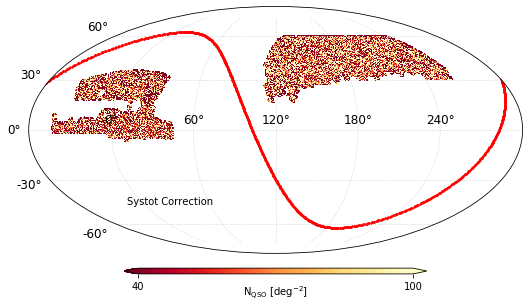

In [13]:

#--- uncomment to add EBV
# import pandas as pd
# df = pd.read_hdf('/home/mehdi/data/templates/SDSS_WISE_HI_imageprop_nside512.h5', 'templates')
# ebv = hp.ud_grade(df.ebv, nside_out=64)
# ebv[~mask]= np.nan

fig = plt.figure(figsize=(7, 4)) # matplotlib is doing the mollveide projection
#ax  = fig.add_subplot(211, projection='mollweide')
#ax1 = fig.add_subplot(312, projection='mollweide')
ax2 = fig.add_subplot(111, projection='mollweide')


spacing = 0.01
plt.subplots_adjust(bottom=spacing, top=1-spacing, 
                    left=spacing, right=1-spacing,
                    hspace=0.0)


kw = dict(unit=r'N$_{{\rm QSO}}$ [deg$^{-2}$]', cmap=plt.cm.YlOrRd_r, 
         vmin=40, vmax=100, #width=6, 
         extend='both', galaxy=True)

#dv.mollview(density0, figax=[fig, ax], **kw)
# dv.mollview(ebv, figax=[fig, ax1], galaxy=True, vmin=0, 
#             vmax=0.1, cmap=plt.cm.Reds, unit='')
dv.mollview(density1, figax=[fig, ax2], colorbar=True, **kw)

#ax.text(0.2, 0.2, 'No Correction', transform=ax.transAxes)
#ax1.text(0.2, 0.2, 'E(B-V)', transform=ax1.transAxes)
ax2.text(0.2, 0.2, 'Systot Correction', transform=ax2.transAxes)
ax2.grid(True, ls=':', color='grey', alpha=0.4)
plt.savefig('./figs/fig2-mollweide.pdf', 
            bbox_inches='tight', dpi=300, rasterized=True)

# predicted number density

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater


........

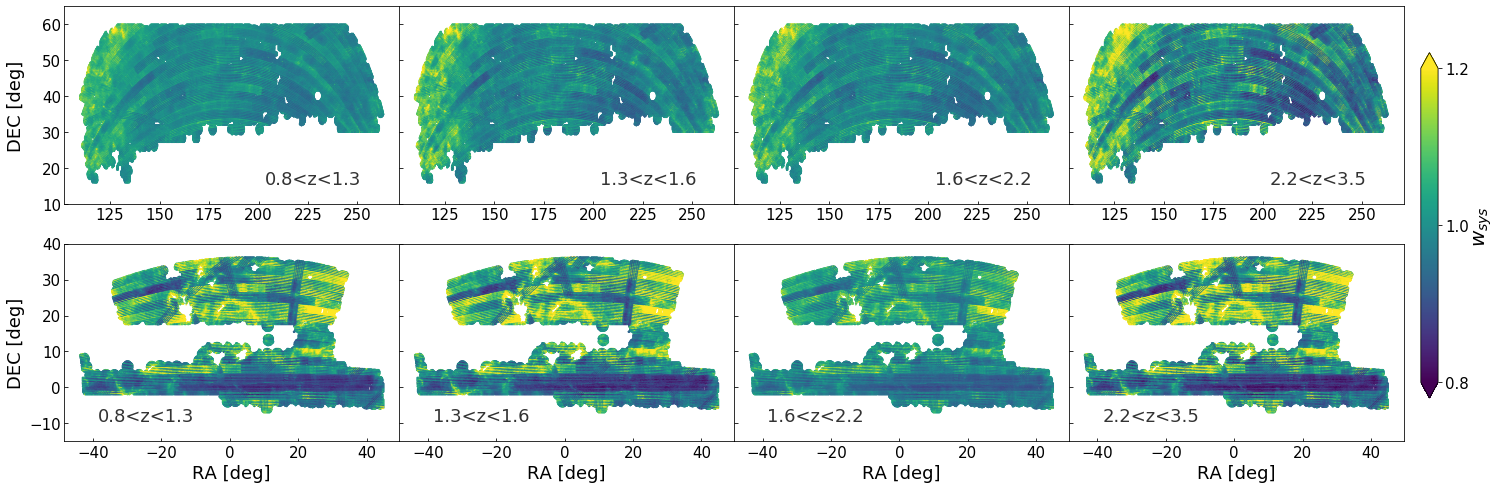

In [2]:
#pdf = matplotlib.backends.backend_pdf.PdfPages('figs/wsys_nn_known_p2_v7_2.pdf')
ncols = 4
fig, ax = plt.subplots(ncols=ncols, nrows=2, figsize=(6*ncols, 8), 
                       sharey='row', sharex='row')
fig.subplots_adjust(wspace=0.0)
fig.align_labels()
ax= ax.flatten()

for j,cap in enumerate(['NGC', 'SGC']):
    
    path1 = '/home/mehdi/data/eboss/v7_2/0.3/results/'
    path2 = 'regression/nn_known/nn-weights.hp512.fits'
    wmaps = [path1 + f'{cap}_{z}_512/' + path2 for z in ['z1', 'z2', 'z3', 'zhigh']]


    # read maps
    dwmaps = []
    for wmap in wmaps:
        dwmaps.append(hp.read_map(wmap, verbose=False))


    zlims = [[0.8, 1.3], [1.3, 1.6], [1.6, 2.2], [2.2, 3.5]]



    kw = dict(vmax=1.2, vmin=0.8, cmap=plt.cm.viridis, marker='.', rasterized=True)

    for i,dwmap in enumerate(dwmaps):
        print('.', end='')

        ix = j*4+i
        
        hpix = np.argwhere(dwmap > 0).flatten()
        ra, dec = hpix2radec(512, hpix)

        mapi = ax[ix].scatter(shiftra(ra), dec, 1,
                    c=1/dwmap[hpix], **kw)

        if ix <4:
            ax[ix].set_ylim(10, 65)
            xtext = 0.6
        else:
            xtext = 0.1
            ax[ix].set_ylim(-15, 40)

        ax[ix].text(xtext, 0.1, '{}<z<{}'.format(*zlims[i]), 
                    color='k', transform=ax[ix].transAxes, fontsize=18, alpha=0.8)            
        
        ax[ix].tick_params(direction='in', axis='both', which='both', labelsize=15)
        
        if j==1:
            ax[ix].set_xlabel('RA [deg]', fontsize=18) # title='{0}<z<{1}'.format(*zlim)

        if i==0:ax[ix].set_ylabel('DEC [deg]', fontsize=18)

cax = plt.axes([0.91, 0.2, 0.01, 0.6])
cbar = fig.colorbar(mapi, cax=cax,
             shrink=0.7, ticks=[0.8, 1.0, 1.2], extend='both')
cbar.set_label(label=r'$w_{sys}$', size=20)
cbar.ax.tick_params(labelsize=15)
fig.savefig('figs/fig3-wsys.pdf', bbox_inches='tight')
#pdf.savefig(1, bbox_inches='tight')    
#pdf.close()

# Clustering

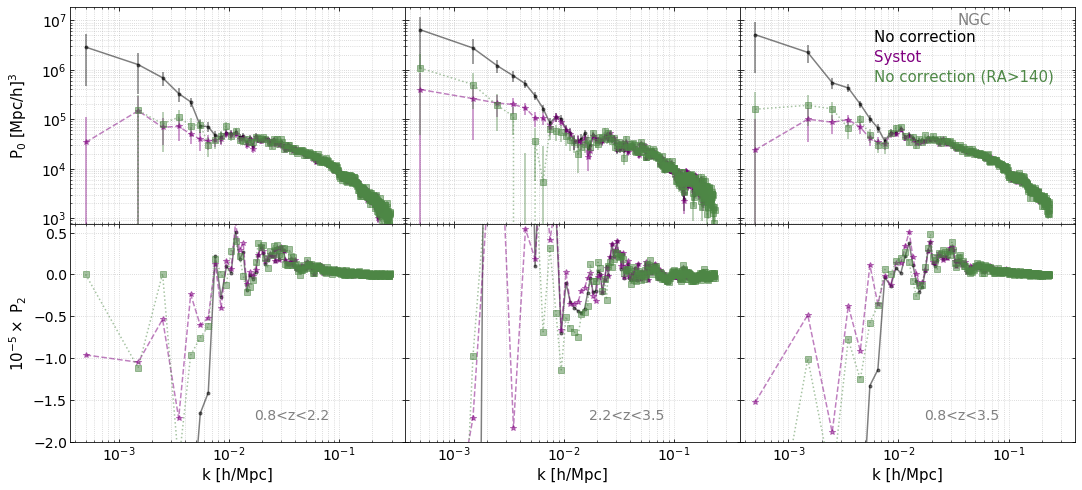

In [16]:
pdfname = 'figs/fig4-pkradec.pdf'

caps = ['NGC'] # only NGC makes sense
samples = ['standard', 'zhigh', 'combined']
treatments = ['No correction', 'Systot', 'No correction (RA>140)']
models  = ['wosystot', 'wsystot', 'wosystot_racut']
#treatments = ['No correction (RA cut)', 'Systot (RA cut)']
#models  = ['wosystot_racut', 'wsystot_racut']

mk = ['.', '*', 's', '^', '>', 'o']
c = ['k', 'purple', '#4d8745', 'purple']

ls = 2*['-', '--', ':', '-.']
path = '/home/mehdi/data/eboss/v7_2/0.3/'
pkout = lambda cap, model, sample : f'pk_{cap}_v7_2_0.3_{model}_512_{sample}.txt'
labels = {'standard':'0.8<z<2.2',
           'zhigh':'2.2<z<3.5',
          'combined':'0.8<z<3.5'} 



pdf = matplotlib.backends.backend_pdf.PdfPages(pdfname) 
pdf_i = 0

for cap in caps:    
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8), 
                           sharey='row', sharex=True)
    ax = ax.flatten()
    fig.subplots_adjust(wspace=0.0, hspace=0.0)

    for j, sample in enumerate(samples):

        for i,model in enumerate(models):

            pk_i, shotnoise = readnbodykit(path + pkout(cap, model, sample))
            
            err = pk_i[:,2]/(0.5*pk_i[:,5])**0.5
            
            # monopole
            ax[j].errorbar(pk_i[:,0], pk_i[:,2]-shotnoise,
                           yerr=err,
                           label=treatments[i], ls=ls[i], c=c[i], marker=mk[i], alpha=0.5)
            
            # quadrupole
            ax[j+3].errorbar(pk_i[:,0], pk_i[:,3]/1e5,
                           label=treatments[i], ls=ls[i], c=c[i], marker=mk[i], alpha=0.5)

    ##-- cosmetics
    # redshifts
    for i, sample in enumerate(samples):
        ax[i+3].text(0.55, 0.1, 
                   labels[sample], 
                   color='grey',
                   transform=ax[i+3].transAxes,
                    fontsize=14)




    # labels
    ax[2].text(0.65, 0.92, cap.upper(), color='grey', 
               transform=ax[2].transAxes, fontsize=15)
    for i in range(len(models)):
        j == 2 # top right
        ax[j].text(0.4, 0.84-i*0.09, 
                   treatments[i], 
                   color=c[i], 
                   transform=ax[j].transAxes,
                   fontsize=15)

    # x-y axes labels
    for i, axi in enumerate(ax):
        axi.tick_params(direction='in', axis='both', which='both',
                       right=True, top=True, labelsize=14)
        axi.set(xscale='log')#, yscale='log')
        axi.grid(True, ls=':', color='grey', which='both', alpha=0.4)
        if i<3:
            axi.set_yscale('log')
            if i==0:
                axi.set_ylabel(r'P$_{0}$ [Mpc/h]$^{3}$', fontsize=15)
        else:
            axi.set_xlabel('k [h/Mpc]', fontsize=15)
            if i==3:
                axi.set_ylim(-2, 0.6)
                axi.set_ylabel(r'10$^{-5} \times$ P$_{2}$', fontsize=15)
    fig.align_labels()
    pdf.savefig((pdf_i+1), bbox_inches='tight')
pdf.close()

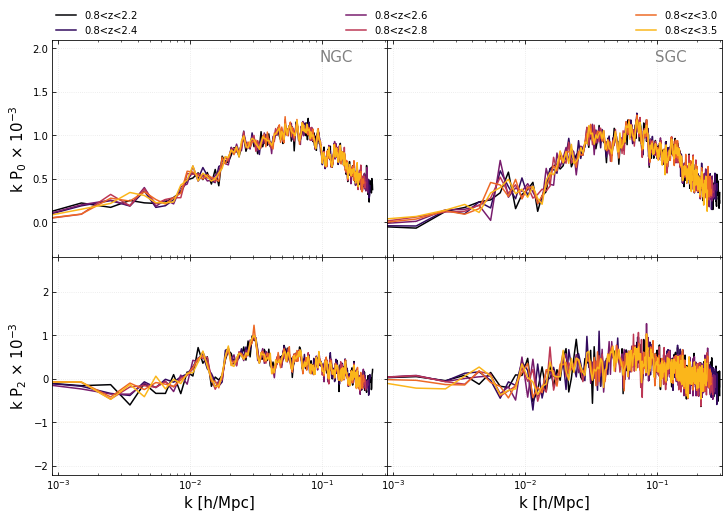

In [40]:
caps = ['NGC', 'SGC']
samples = ['standard', 'zextend2.4', 'zextend2.6', 'zextend2.8',  'zextend3.0', 'combined']
treatments = ['systot']
models  = ['wsystot']

mk = ['.', '*', 's', '^', '>', 'o']
c = [plt.cm.inferno(i/len(samples)) for i in range(len(samples))]
ls = 2*['-', '--', ':', '-.']
path = '/home/mehdi/data/eboss/v7_2/0.3/'
pkout = lambda cap, model, sample : f'pk_{cap}_v7_2_0.3_{model}_512_{sample}.txt'
labels = {'zhigh':'2.2<z<3.5',
          'standard':'0.8<z<2.2',
          'zextend2.4':'0.8<z<2.4',
          'zextend2.6':'0.8<z<2.6',
          'zextend2.8':'0.8<z<2.8',
          'zextend3.0':'0.8<z<3.0',
          'combined':'0.8<z<3.5'} 

legendkw = dict(ncol=3, frameon=False,
                 bbox_to_anchor=(0.0, 1.0, 2., 0.4), loc="lower left",
                 mode="expand", borderaxespad=0)

ncols=2
fig, ax = plt.subplots(ncols=ncols, nrows=2, 
                       figsize=(6*ncols, 8), 
                       sharey='row', sharex=True)
ax = ax.flatten()
fig.subplots_adjust(wspace=0.0, hspace=0.0)

for k,cap in enumerate(caps):    

    for j, sample in enumerate(samples):

        for i,model in enumerate(models):

            pk_i, shotnoise = readnbodykit(path + pkout(cap, model, sample))
            
            # quadrupole
            #positive = pk_i[:,3]>0
            ax[k].plot(pk_i[:,0], pk_i[:,0]*(pk_i[:,2]-shotnoise)/1.0e3,
                           label=labels[sample], c=c[j], ls='-')

            ax[k+2].plot(pk_i[:,0], pk_i[:,0]*pk_i[:,3]/1.0e3,
                           label=labels[sample], c=c[j], ls='-')

            
    
    ax[k].set_ylim(-0.4, 2.1)
    ax[k+2].set_ylim(-2.2, 2.8)
    ax[k].set(xlim=(0.0009, 0.31))
    ax[k+2].set(xlim=(0.0009, 0.31))#xscale='log')
    ax[k+2].set_xlabel('k [h/Mpc]', fontsize=15)

    ax[k].grid(True, ls=':',   color='grey', which='major', alpha=0.2)
    ax[k+2].grid(True, ls=':', color='grey', which='major', alpha=0.2)
    
    if k==0:
        ax[k].legend(**legendkw)
    if k%2 == 0:
        ax[k].set_ylabel(r'k P$_{0}$ $\times$ 10$^{-3}$', fontsize=15)
        ax[k+2].set_ylabel(r'k P$_{2}$ $\times$ 10$^{-3}$', fontsize=15)
        
    ax[k].text(0.8, 0.9, cap.upper(), color='grey',
               transform=ax[k].transAxes, fontsize=15)

for axi in ax:
    axi.set_xscale('log')
    axi.tick_params(direction='in', axis='both', 
                    which='both', right=True, top=True)
fig.align_labels()
fig.savefig('figs/fig5-pk_standardzmax.pdf', bbox_inches='tight')

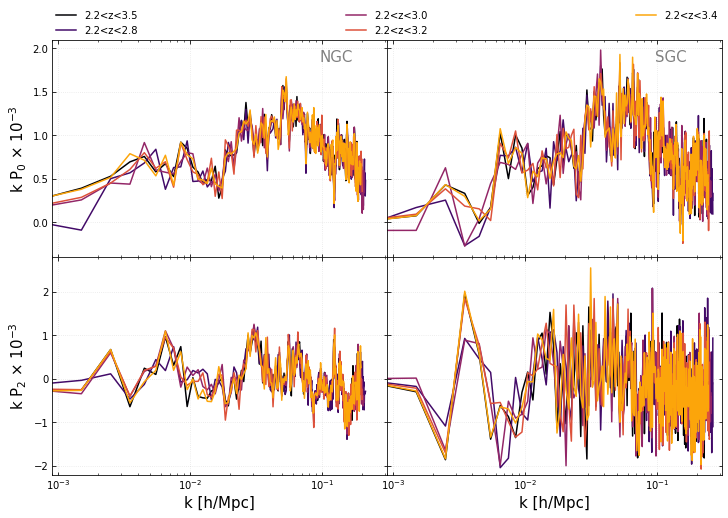

In [39]:
caps = ['NGC', 'SGC']
samples = ['zhigh', 'hizextend2.8', 'hizextend3.0', 'hizextend3.2', 'hizextend3.4']
treatments = ['systot']
models  = ['wsystot']

mk = ['.', '*', 's', '^', '>', 'o']
c = [plt.cm.inferno(i/len(samples)) for i in range(len(samples))]
ls = 2*['-', '--', ':', '-.']
path = '/home/mehdi/data/eboss/v7_2/0.3/'
pkout = lambda cap, model, sample : f'pk_{cap}_v7_2_0.3_{model}_512_{sample}.txt'

labels = {'zhigh':'2.2<z<3.5',
          'standard':'0.8<z<2.2',
          'zextend2.4':'0.8<z<2.4',
          'zextend2.6':'0.8<z<2.6',
          'zextend2.8':'0.8<z<2.8',
          'zextend3.0':'0.8<z<3.0',
          'combined':'0.8<z<3.5',
          'hizextend2.8':'2.2<z<2.8',
          'hizextend3.0':'2.2<z<3.0',          
          'hizextend3.2':'2.2<z<3.2',
          'hizextend3.4':'2.2<z<3.4'} 

legendkw = dict(ncol=3, frameon=False,
                 bbox_to_anchor=(0.0, 1.0, 2., 0.4), loc="lower left",
                 mode="expand", borderaxespad=0)

ncols=2
fig, ax = plt.subplots(ncols=ncols, nrows=2, 
                       figsize=(6*ncols, 8), 
                       sharey='row', sharex=True)
ax = ax.flatten()
fig.subplots_adjust(wspace=0.0, hspace=0.0)

for k,cap in enumerate(caps):    

    for j, sample in enumerate(samples):

        for i,model in enumerate(models):

            pk_i, shotnoise = readnbodykit(path + pkout(cap, model, sample))
            
            # quadrupole
            #positive = pk_i[:,3]>0
            ax[k].plot(pk_i[:,0], pk_i[:,0]*(pk_i[:,2]-shotnoise)/1.0e3,
                           label=labels[sample], c=c[j], ls='-')

            ax[k+2].plot(pk_i[:,0], pk_i[:,0]*pk_i[:,3]/1.0e3,
                           label=labels[sample], c=c[j], ls='-')

            
    
    ax[k].set_ylim(-0.4, 2.1)
    ax[k+2].set_ylim(-2.2, 2.8)
    ax[k].set(xlim=(0.0009, 0.31))
    ax[k+2].set(xlim=(0.0009, 0.31))#xscale='log')
    ax[k+2].set_xlabel('k [h/Mpc]', fontsize=15)

    ax[k].grid(True, ls=':',   color='grey', which='major', alpha=0.2)
    ax[k+2].grid(True, ls=':', color='grey', which='major', alpha=0.2)
    
    if k==0:
        ax[k].legend(**legendkw)
    if k%2 == 0:
        ax[k].set_ylabel(r'k P$_{0}$ $\times$ 10$^{-3}$', fontsize=15)
        ax[k+2].set_ylabel(r'k P$_{2}$ $\times$ 10$^{-3}$', fontsize=15)
        
    ax[k].text(0.8, 0.9, cap.upper(), color='grey',
               transform=ax[k].transAxes, fontsize=15)

for axi in ax:
    axi.set_xscale('log')
    axi.tick_params(direction='in', axis='both', 
                    which='both', right=True, top=True)
fig.align_labels()
fig.savefig('figs/fig6-pk_highzmax.pdf', bbox_inches='tight')

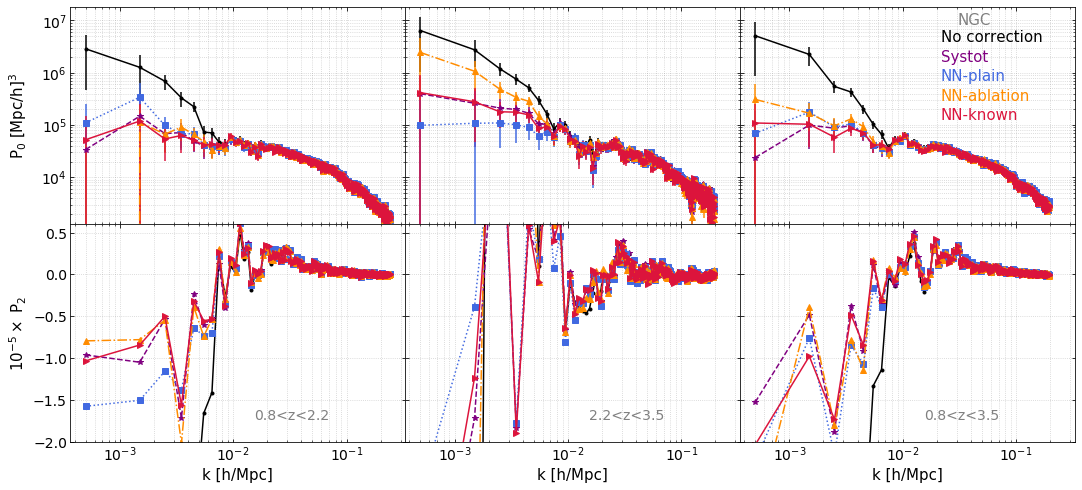

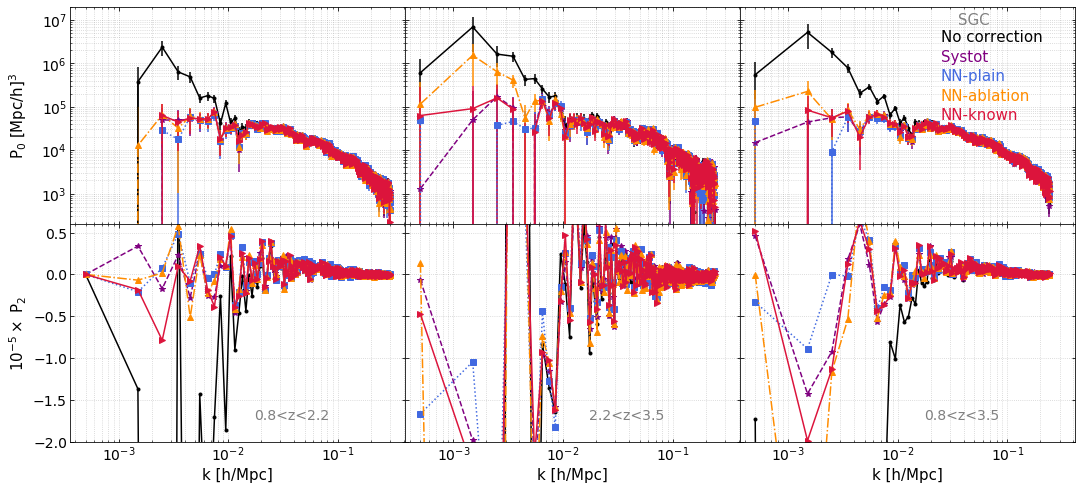

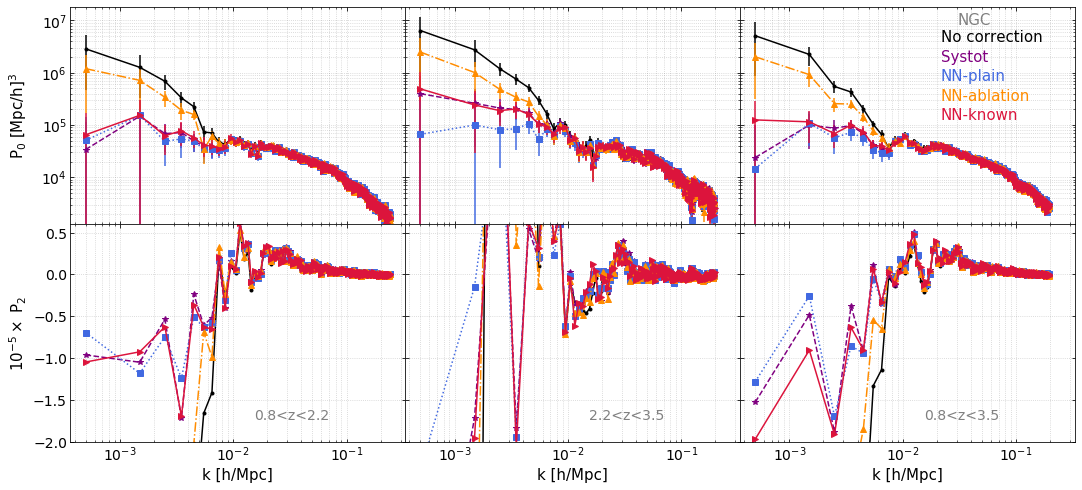

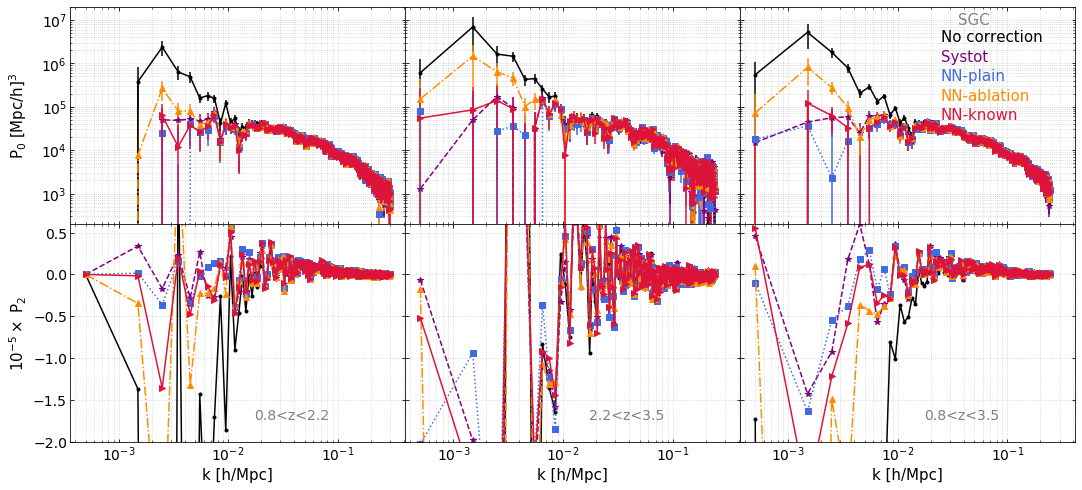

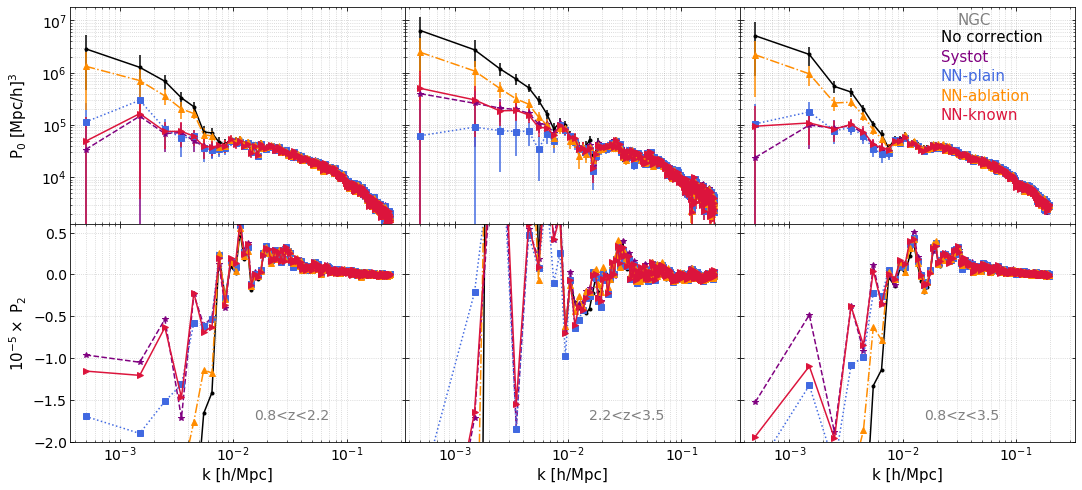

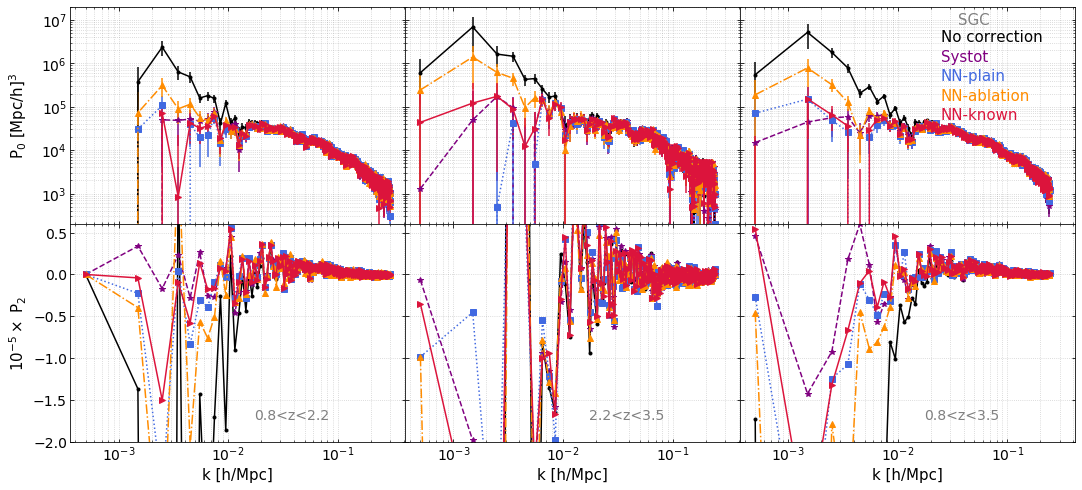

In [43]:
pdfname = 'figs/eboss_qso_v7_2_p3.pdf'

caps = ['NGC', 'SGC']
samples = ['standard', 'zhigh', 'combined']
treatments = ['No correction', 'Systot',   'NN-plain', 'NN-ablation', 'NN-known']

models2z  = ['wosystot', 'wsystot',  'plain_allhigh', 'ablation_allhigh', 'known_allhigh']
models3z  = ['wosystot', 'wsystot',  'plain_lowmidhigh', 'ablation_lowmidhigh', 'known_lowmidhigh']
models4z  = ['wosystot', 'wsystot',  'plain_z3high', 'ablation_z3high', 'known_z3high']

mk = ['.', '*', 's', '^', '>', 'o']
c = ['k', 'purple', 'royalblue', 'darkorange', 'crimson']
#c = [plt.cm.gnuplot(i/len(models)) for i in range(len(models))]

ls = 2*['-', '--', ':', '-.']
path = '/home/mehdi/data/eboss/v7_2/0.3/'
pkout = lambda cap, model, sample : f'pk_{cap}_v7_2_0.3_{model}_512_{sample}.txt'
labels = {'standard':'0.8<z<2.2',
           'zhigh':'2.2<z<3.5',
          'combined':'0.8<z<3.5'} 



pdf = matplotlib.backends.backend_pdf.PdfPages(pdfname) 

pdf_i = 0
for k, models in enumerate([models2z, models3z, models4z]):
    
    for cap in caps:    
        fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8), 
                               sharey='row', sharex=True)
        ax = ax.flatten()
        fig.subplots_adjust(wspace=0.0, hspace=0.0)

        for j, sample in enumerate(samples):

            for i,model in enumerate(models):
                
                kwargs = dict(label=treatments[i], ls=ls[i], c=c[i], marker=mk[i])
                
                pk_i, shotnoise = readnbodykit(path + pkout(cap, model, sample))

                err = pk_i[:,2]/(0.5*pk_i[:,5])**0.5

                # monopole
                ax[j].errorbar(pk_i[:,0], pk_i[:,2]-shotnoise, yerr=err, **kwargs)

                # quadrupole
                #if (model=='wosystot') | ('ablation' in model):
                #    continue
                ax[j+3].errorbar(pk_i[:,0], pk_i[:,3]/1e5, **kwargs)

        ##-- cosmetics
        # redshifts
        for i, sample in enumerate(samples):
            ax[i+3].text(0.55, 0.1, 
                       labels[sample], 
                       color='grey',
                       transform=ax[i+3].transAxes,
                        fontsize=14)




        # labels
        ax[2].text(0.65, 0.92, cap.upper(), color='grey', 
                   transform=ax[2].transAxes, fontsize=15)
        for i in range(len(models)):
            j == 2 # top right
            ax[j].text(0.6, 0.84-i*0.09, 
                       treatments[i], 
                       color=c[i], 
                       transform=ax[j].transAxes,
                       fontsize=15)

        # x-y axes labels
        for i, axi in enumerate(ax):
            axi.tick_params(direction='in', axis='both', which='both',
                           right=True, top=True, labelsize=14)
            axi.set(xscale='log')#, yscale='log')
            axi.grid(True, ls=':', color='grey', which='both', alpha=0.4)
            if i<3:
                axi.set_yscale('log')
                if i==0:
                    axi.set_ylabel(r'P$_{0}$ [Mpc/h]$^{3}$', fontsize=15)
            else:
                axi.set_xlabel('k [h/Mpc]', fontsize=15)
                if i==3:
                    axi.set_ylim(-2, 0.6)
                    axi.set_ylabel(r'10$^{-5} \times$ P$_{2}$', fontsize=15)

        fig.align_labels()
        pdf.savefig((pdf_i+1), bbox_inches='tight')
        pdf_i += 1
pdf.close()  

In [14]:
pk_old = readnbodykit('/B/Shared/mehdi/eboss/data/v7_2/0.2/pk_NGC_v7_2_0.2_plain_lowmidhigh_512_standard.txt')
pk_new = readnbodykit('/B/Shared/mehdi/eboss/data/v7_2/0.3/pk_NGC_v7_2_0.3_plain_lowmidhigh_512_standard.txt')

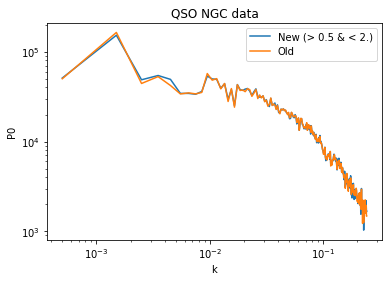

In [18]:
for ni, pki in zip(['New (> 0.5 & < 2.)', 'Old'], [pk_new, pk_old]):
    ki = pki[0][:, 0]
    p0i = pki[0][:, 2] - pki[1]
    plt.loglog(ki, p0i, label=ni)
    
plt.xlabel('k');plt.ylabel('P0');plt.title('QSO NGC data')
plt.legend()

In [28]:
from glob import glob

In [29]:
nbars = glob('/B/Shared/mehdi/eboss/data/v7_2/0.3/clustering/*NGC*.npy')

In [30]:

# --- 
nnbar = {}
for nbi in nbars:
    keyi = nbi.split('/')[-1][10:-4]
    nnbar[keyi] = np.load(nbi, allow_pickle=True)

In [31]:
chi2 = lambda y,ye: (((y-1)*(y-1))/(ye*ye)).mean()
chi2d = {}

for k in nnbar.keys():
    
    chi2l = []
    for nbi in nnbar[k]:
        chi2l.append(chi2(nbi['nnbar'], nbi['nnbar_err']))
    
    chi2d[k] = chi2l

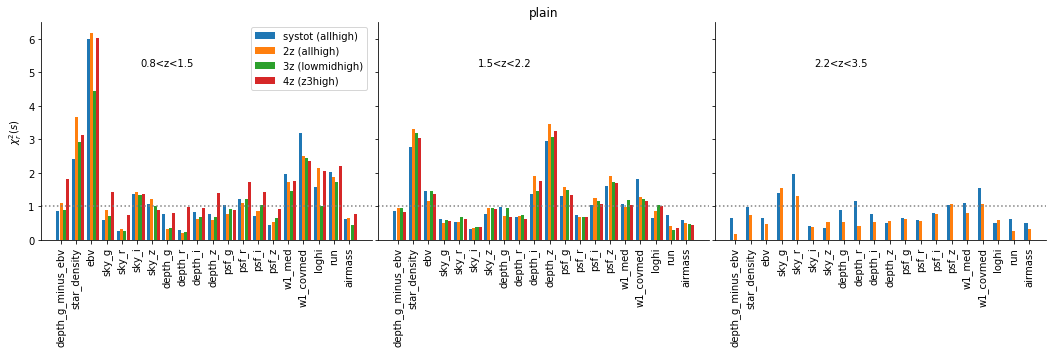

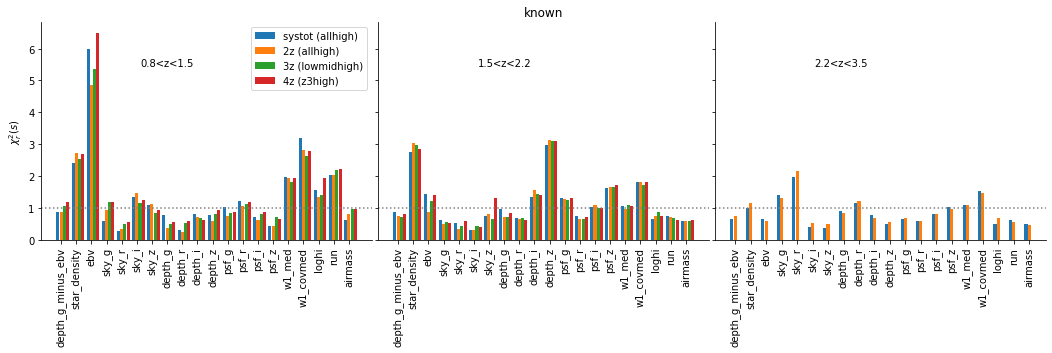

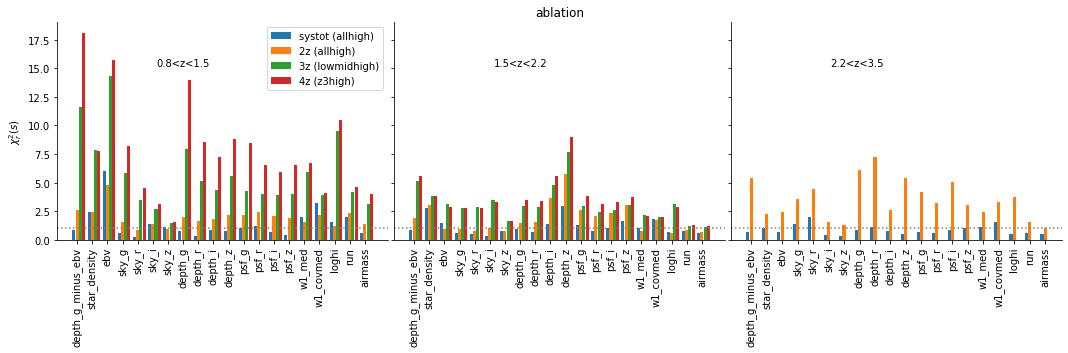

In [113]:
pdf = matplotlib.backends.backend_pdf.PdfPages('figs/chi2_nbar.pdf') 


pdf_i = 0
for model in ['plain', 'known', 'ablation']:
    

    fig, axs = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
    fig.subplots_adjust(wspace=0.02)
    axs = axs.flatten()

    labels = {'low':'0.8<z<1.5',
             'high':'1.5<z<2.2',
             'zhigh':'2.2<z<3.5'}

    #model = 'plain'


    for (ax, zr) in zip(axs, ['low', 'high', 'zhigh']):

        ax.bar(np.arange(20)-0.21, chi2d[f'NGC_systot_{zr}'], width=0.2, label='systot (allhigh)')
        ax.bar(np.arange(20), chi2d[f'NGC_{model}_allhigh_{zr}'], width=0.2, label='2z (allhigh)')

        if zr != 'zhigh':        
            ax.bar(np.arange(20)+0.21, chi2d[f'NGC_{model}_lowmidhigh_{zr}'], width=0.2, label='3z (lowmidhigh)')            
            ax.bar(np.arange(20)+0.42, chi2d[f'NGC_{model}_z3high_{zr}'], width=0.2, label='4z (z3high)')

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # ax.spines['left'].set_position(('outward', 5))
        # ax.spines['bottom'].set_position(('outward', 5))

        ax.axhline(1, ls=':', color='grey')
        ax.set_xticks(np.arange(20))
        
        if zr == 'high':
            ax.set_title(model)
            
        if zr == 'low':
            ax.legend()
            ax.set_ylabel(r'$\chi_{r}^{2}(s)$')
            
        #ax.set_ylim(0, 20)
        ax.text(0.3, 0.8, labels[zr], transform=ax.transAxes)
        _=ax.set_xticklabels(xlabels, rotation=90)
        
    #plt.show()
    pdf.savefig((pdf_i+1), bbox_inches='tight')
    pdf_i += 1
pdf.close()  

In [32]:
from LSSutils.lab import datarelease as dl

In [33]:
xlabels = dl.cols_eboss_mocks_qso

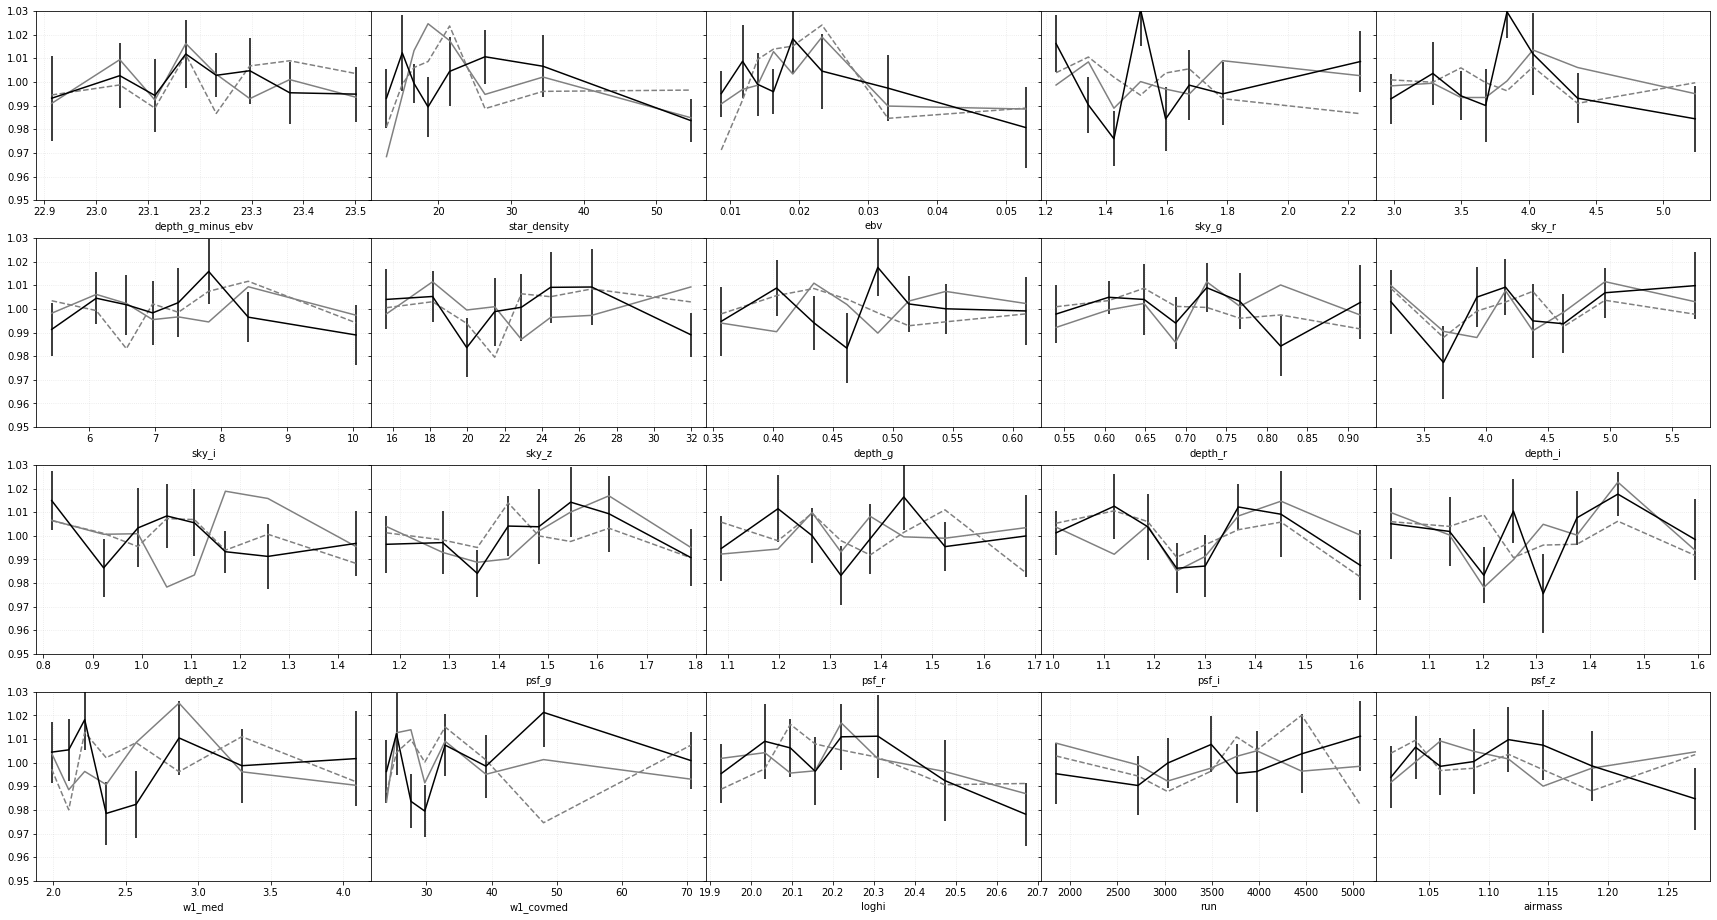

In [35]:
def add_plot(nnbar, ax, error=False, **kw):
    
    for i, nnbar_i in enumerate(nnbar):
        x = nnbar_i['bin_avg']
        y = nnbar_i['nnbar']
        ye = nnbar_i['nnbar_err']

        if error:
            ax[i].errorbar(x, y, ye, **kw)
        else:
            ax[i].plot(x, y, **kw)


fig, ax = plt.subplots(ncols=5, nrows=4, 
                       figsize=(30, 16), sharey=True)
fig.subplots_adjust(wspace=0)
ax = ax.flatten()


cap = 'NGC'
model = 'plain_lowmidhigh' #'systot'
zr = ['low', 'high', 'zhigh']


color = {'low':'grey', 
         'high':'grey',
         'zhigh':'k'}

ls = {'low':'--',
     'high':'-',
     'zhigh':'-'}


for zi in zr:
    
    ki = f'{cap}_{model}_{zi}'
    error = True if zi=='zhigh' else False
    
    add_plot(nnbar[ki], ax, error=error, color=color[zi], ls=ls[zi])


for i, ai in enumerate(ax):
    ai.set_xlabel(xlabels[i])
    ai.grid(True, ls=':', color='grey', alpha=0.2)
    ai.set_ylim(0.95, 1.03)

# mocks

In [25]:
path = '/B/Shared/mehdi/eboss/mocks/0.3/'
pk_dict = {}

for cont in ['null', 'contaminated']:
    for model in ['ablation', 'known', 'plain', 'nowsys', 'systot', 'truth']:
        
        if (cont == 'null') & (model == 'nowsys'):
            continue
        
        if (cont == 'contaminated') & (model == 'truth'):
            continue
        
        for zsplit in ['all', 'lowmid', 'z3']:
            
            if (model in ['nowsys', 'systot', 'truth']) & (zsplit != 'all'):
                continue
            
            pk0 = []
            pk2 = []
            
            for i in range(1,10):                
                pktxt = f'{path}NGC_{i:04d}_{cont}/pk_QSO_NGC_v7_0.3_{model}_{zsplit}_{i:04d}_{cont}_512_standard.txt'

                pkdata, shotnoise = readnbodykit(pktxt)
                pk0.append(pkdata[:,2]-shotnoise)
                pk2.append(pkdata[:,3])
            
            name = '_'.join([cont, model, zsplit])
            pk_dict[name] = (pkdata[:, 0], np.mean(pk0, axis=0), np.mean(pk2, axis=0))
            print(name)

null_ablation_all
null_ablation_lowmid
null_ablation_z3
null_known_all
null_known_lowmid
null_known_z3
null_plain_all
null_plain_lowmid
null_plain_z3
null_systot_all
null_truth_all
contaminated_ablation_all
contaminated_ablation_lowmid
contaminated_ablation_z3
contaminated_known_all
contaminated_known_lowmid
contaminated_known_z3
contaminated_plain_all
contaminated_plain_lowmid
contaminated_plain_z3
contaminated_nowsys_all
contaminated_systot_all


In [26]:
colors = {}
for i, key in enumerate(pk_dict.keys()):
    colors[key] = plt.cm.jet(i/22)

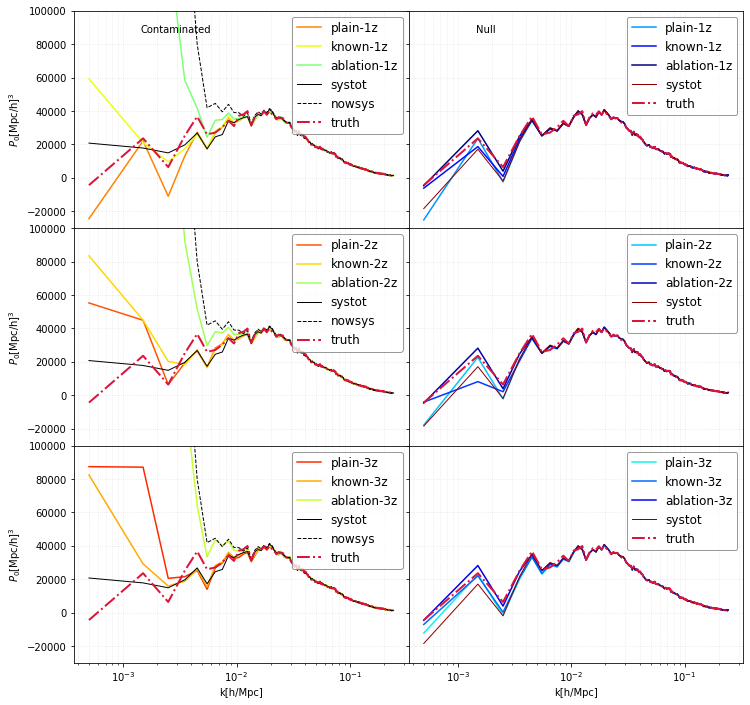

In [27]:
fig, ax = plt.subplots(ncols=2, 
                       nrows=3,
                       figsize=(12, 12), 
                       sharey=True, sharex=True)
ax = ax.flatten()
fig.subplots_adjust(hspace=0, wspace=0)


# -- draw the nn-based
zsplits_l = {'all':'1z',
             'lowmid':'2z',
             'z3':'3z'}

zsplits= ['all', 'lowmid', 'z3']
for j,zsplit in enumerate(zsplits):
    
    for i, model in enumerate(['plain', 'known', 'ablation']):
        ix = 2*j
        
        label = '-'.join([model, zsplits_l[zsplit]])
        name = f'contaminated_{model}_{zsplit}'
        ax[ix].plot(pk_dict[name][0], pk_dict[name][1], color=colors[name], label=label)

        name = f'null_{model}_{zsplit}'
        ax[ix+1].plot(pk_dict[name][0], pk_dict[name][1], color=colors[name], label=label)       

for j in range(3):
    ix = 2*j        
    
    name = f'contaminated_systot_all'
    ax[ix].plot(pk_dict[name][0], pk_dict[name][1], color='k', label='systot', lw=1)
    name = f'contaminated_nowsys_all'
    ax[ix].plot(pk_dict[name][0], pk_dict[name][1], color='k', label='nowsys', ls='--', lw=1)
    

    name = f'null_systot_all'
    ax[ix+1].plot(pk_dict[name][0], pk_dict[name][1], color='#8a0000', label='systot', lw=1)
    
    name = f'null_truth_all'
    kw = dict(color='crimson',  label='truth', ls='-.', lw=2)
    ax[ix].plot(pk_dict[name][0], pk_dict[name][1], **kw)    
    ax[ix+1].plot(pk_dict[name][0], pk_dict[name][1], **kw)

       
for i, axi in enumerate(ax):
    axi.set_xscale('log')
    axi.set_ylim(-3.0e4, 1.0e5)
    axi.grid(True, ls=':', color='grey', alpha=0.2, which='both')
    axi.legend(loc='upper right', fontsize=12, facecolor='w', edgecolor='grey')
    
    if i%2==0:
        axi.set_ylabel(r'$P_{0}$[Mpc/h]$^{3}$')
        
    if i > 3:
        axi.set_xlabel(r'k[h/Mpc]')
    

for i, cont in enumerate(['Contaminated', 'Null']):
    ax[i].text(0.2, 0.9, cont, transform=ax[i].transAxes)

## sky coverage

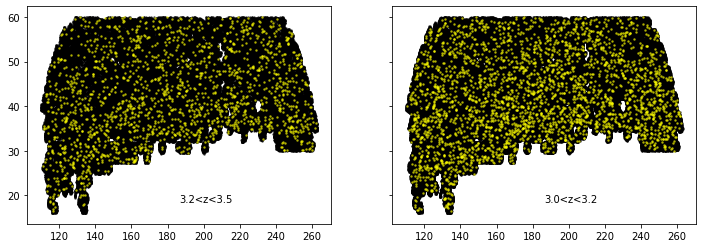

In [39]:
#---
gmask = (dNGC['Z'] > 3.2) & (dNGC['Z'] < 3.5)
rmask = (rNGC['Z'] > 3.2) & (rNGC['Z'] < 3.5)
#--- 
gmask1 = (dNGC['Z'] > 3.0) & (dNGC['Z'] < 3.2)
rmask1 = (rNGC['Z'] > 3.0) & (rNGC['Z'] < 3.2)


fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

labels = ['3.2<z<3.5', '3.0<z<3.2']
i = 0
for (g_i, r_i) in zip([gmask, gmask1], [rmask, rmask1]):
    
    # --- 
    ax[i].scatter(rNGC['RA'][r_i], rNGC['DEC'][r_i], 
                10, color='k', marker='.', alpha=0.5)
    ax[i].scatter(dNGC['RA'][g_i], dNGC['DEC'][g_i], 
                10, color='yellow', marker='.', alpha=0.5)
    ax[i].text(0.5, 0.1, labels[i], transform=ax[i].transAxes)
    i += 1

# Selection masks

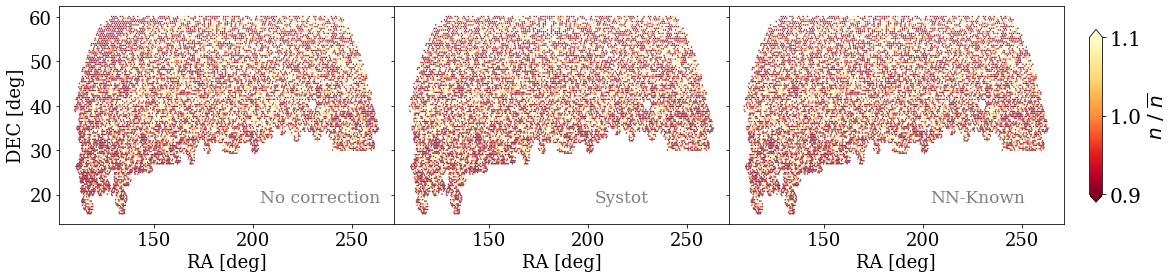

In [3]:
# ---- read data and random
data = ft.read('/home/mehdi/data/eboss/v7_2/0.3/eBOSS_QSO_clustering_NGC_v7_2_0.3.dat.fits')
random = ft.read('/home/mehdi/data/eboss/v7_2/0.3/eBOSS_QSO_clustering_NGC_v7_2_0.3.ran.fits')

data_nn = ft.read('/home/mehdi/data/eboss/v7_2/0.3/eBOSS_QSO_clustering_NGC_v7_2_0.3_known_allhigh.dat.fits')
random_nn = ft.read('/home/mehdi/data/eboss/v7_2/0.3/eBOSS_QSO_clustering_NGC_v7_2_0.3_known_allhigh.ran.fits')



#---- project to HEALPIX
nside  = 128
# hp.nside2resol(nside, arcmin=True)
# 27.483891294539248

hpmaps = {}

# data 
weight = data['WEIGHT_CP']*data['WEIGHT_FKP']*data['WEIGHT_NOZ']
hpmaps['ngal_none'] = hpixsum(nside,  data['RA'], data['DEC'], value=weight)
hpmaps['ngal_systot'] = hpixsum(nside,  data['RA'], data['DEC'], value=weight*data['WEIGHT_SYSTOT'])

weightr = random['WEIGHT_CP']*random['WEIGHT_FKP']*random['WEIGHT_NOZ']*random['WEIGHT_SYSTOT']
hpmaps['nran_systot'] = hpixsum(nside,  random['RA'], random['DEC'], value=weightr)

weight_nn = data_nn['WEIGHT_CP']*data_nn['WEIGHT_FKP']*data_nn['WEIGHT_NOZ']
hpmaps['ngal_nn'] = hpixsum(nside,  data_nn['RA'], data_nn['DEC'], value=weight_nn*data_nn['WEIGHT_SYSTOT'])

weightr_nn = random_nn['WEIGHT_CP']*random_nn['WEIGHT_FKP']*random_nn['WEIGHT_NOZ']*random_nn['WEIGHT_SYSTOT']
hpmaps['nran_nn'] = hpixsum(nside,  random_nn['RA'], random_nn['DEC'], value=weightr_nn)


#---- using Randoms, compute the N/Nbar
# makedelta returns overdensity, we add 1 back to get N/Nbar
deltas = {}
deltas['none'] = overdensity(hpmaps['ngal_none'], hpmaps['nran_systot'], hpmaps['nran_systot']>0) + 1
deltas['systot'] = overdensity(hpmaps['ngal_systot'], hpmaps['nran_systot'], hpmaps['nran_systot']>0) + 1
deltas['nn'] = overdensity(hpmaps['ngal_nn'], hpmaps['nran_nn'], hpmaps['nran_nn']>0) + 1

# np.array_equal(hpmaps['nran_nn']>0, hpmaps['nran_systot']>0)
# True
hpix = np.argwhere(hpmaps['nran_systot']>0).flatten()
ra, dec = hpix2radec(nside, hpix)

#--- set the font, figure size, etc
plt.rc('font', family='serif', size=18)

ncols = 3
fig, ax = plt.subplots(ncols=ncols, nrows=1, figsize=(6*ncols, 4), 
                       sharey='row', sharex='row')
fig.subplots_adjust(wspace=0.0)
ax= ax.flatten()

#--- plot 
kw = dict(vmax=1.1, vmin=0.9, cmap=plt.cm.YlOrRd_r, marker='.', rasterized=True)

ax[0].scatter(ra, dec, 1, c=deltas['none'][hpix], **kw)
ax[1].scatter(ra, dec, 1, c=deltas['systot'][hpix], **kw)
mapi = ax[2].scatter(ra, dec, 1, c=deltas['nn'][hpix], **kw)

#--- cosmetics
for i, (namei,axi) in enumerate(zip(['No correction', 'Systot', 'NN-Known'], ax)):    
    
    axi.set(xlabel='RA [deg]')    
    axi.text(0.6, 0.1, namei, color='grey',
             transform=axi.transAxes, fontsize=17)
    
    if i==0:
        axi.set(ylabel='DEC [deg]')

# colorbar
cax = plt.axes([0.92, 0.2, 0.01, 0.6])
cbar = fig.colorbar(mapi, cax=cax,
             shrink=0.7, ticks=[0.9, 1.0, 1.1], extend='both')
cbar.set_label(label=r'$n~/~\overline{n}$', size=20)
cbar.ax.tick_params(labelsize=20)

# savefig
fig.savefig('figs/qso_ngc_before_after_p3_v7_2.pdf', bbox_inches='tight', dpi=300)